In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# find files to plot

In [2]:
simulation_folder = '/nfshome/winkelmann/CathodeSimulationResults/Lichtenberg_250603/'

simulation_concentrations = glob.glob(simulation_folder + 'Va_*')

simulation_files = {}
for conc in simulation_concentrations:
    concentration = 100 - float(conc.split('/')[-1].strip('Va_'))
    simulation_files[str(concentration)] = glob.glob(conc + '/*/state_snapshot.csv')

# read files and save MSD; Net-MSD and time

In [ ]:
dict_results = {}

for conc,files in simulation_files.items():
    df_msd = pd.DataFrame()
    df_net = pd.DataFrame()
    df_conc = pd.DataFrame()
    for f in files:
        # Read CSV file and strip all whitespace characters (spaces, tabs, newlines)
        df_temp = pd.read_csv(f,sep=r',\s+',skiprows=1, engine='python')
        df_temp.drop(index=df_temp.index[-1], axis=0, inplace=True)  # Skip first row and last row
        simulation_number = f.split('/')[-2]
        df_msd[simulation_number] = df_temp['MSD-Li']
        df_net[simulation_number] = df_temp['Net-MSD']
        if simulation_number == '01':
            df_conc['time'] = df_temp['time in 1e+00 s']             
    df_conc['msd'] = df_msd.mean(axis=1)
    df_conc['net'] = df_net.mean(axis=1)
    df_conc['msd_std'] = df_msd.std(axis=1)
    df_conc['net_std'] = df_net.std(axis=1)
    print(f'NaN time:\t{df_conc["time"].isna().sum()} MSD:\t{df_conc["msd"].isna().sum()} Net:\t{df_conc["net"].isna().sum()} for concentration\t{conc}')
    dict_results[conc] = df_conc

NaN time:	0 NaN MSD:	9 NaN Net:	9 for concentration	75.0
NaN time:	0 NaN MSD:	0 NaN Net:	0 for concentration	50.0
NaN time:	0 NaN MSD:	2 NaN Net:	2 for concentration	46.0
NaN time:	0 NaN MSD:	18 NaN Net:	18 for concentration	40.0
NaN time:	0 NaN MSD:	188 NaN Net:	188 for concentration	33.0
NaN time:	0 NaN MSD:	0 NaN Net:	0 for concentration	25.0
NaN time:	0 NaN MSD:	2 NaN Net:	2 for concentration	63.0
NaN time:	0 NaN MSD:	0 NaN Net:	0 for concentration	13.0
NaN time:	0 NaN MSD:	0 NaN Net:	0 for concentration	88.0


# Plot

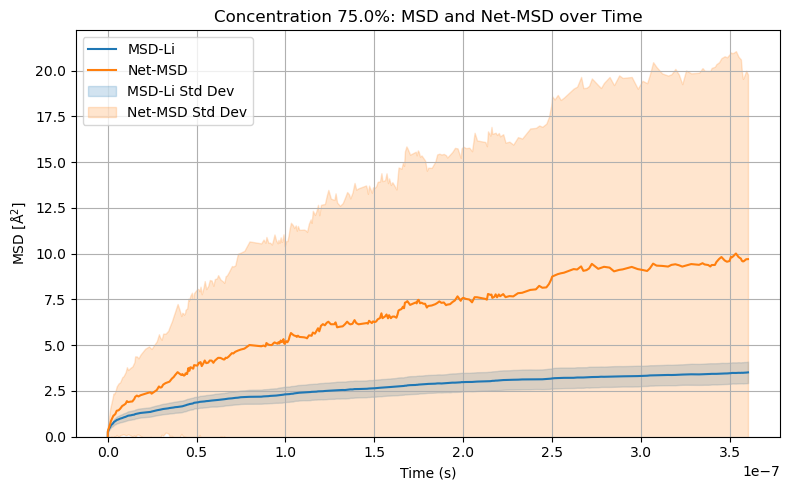

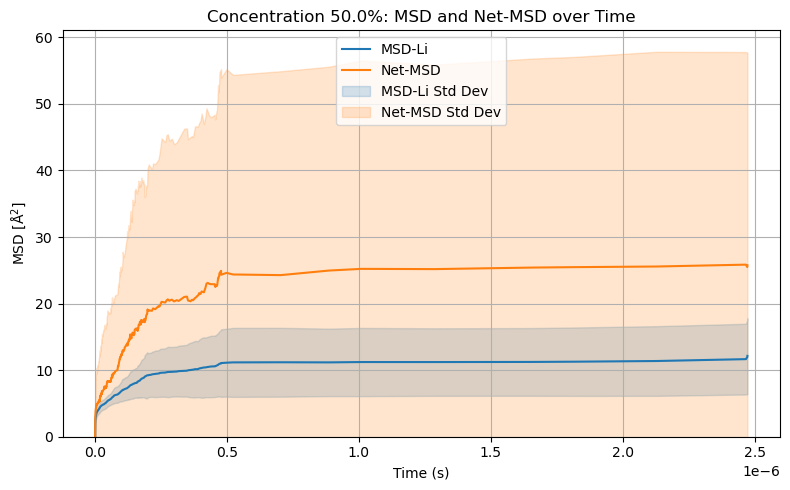

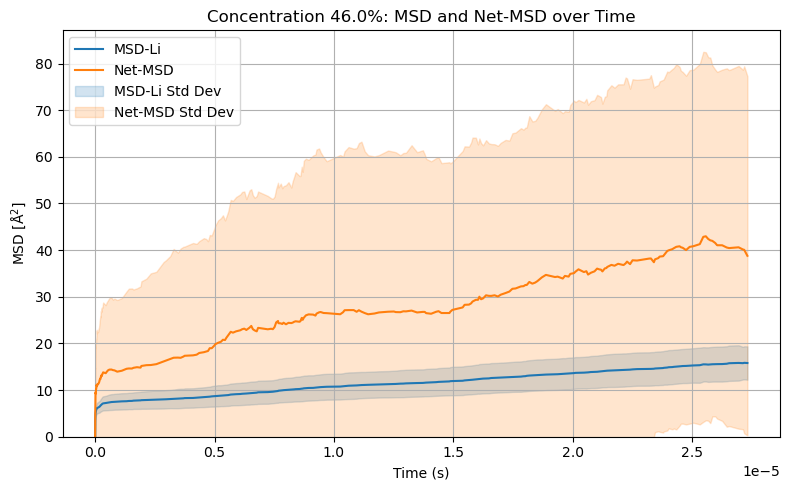

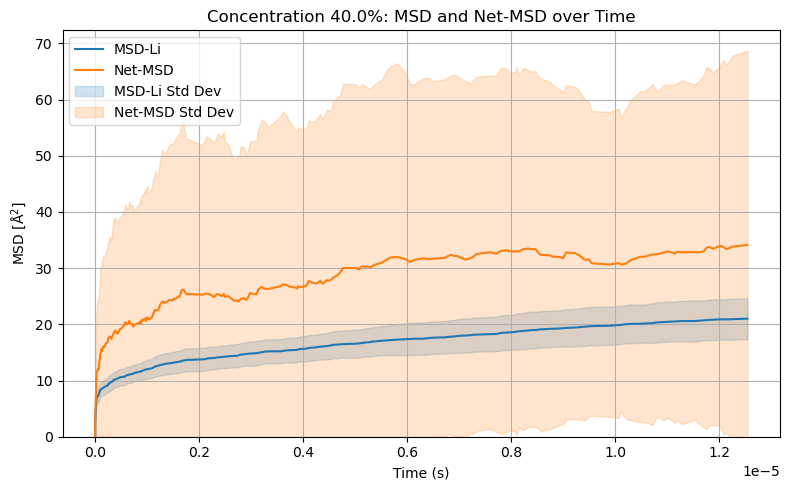

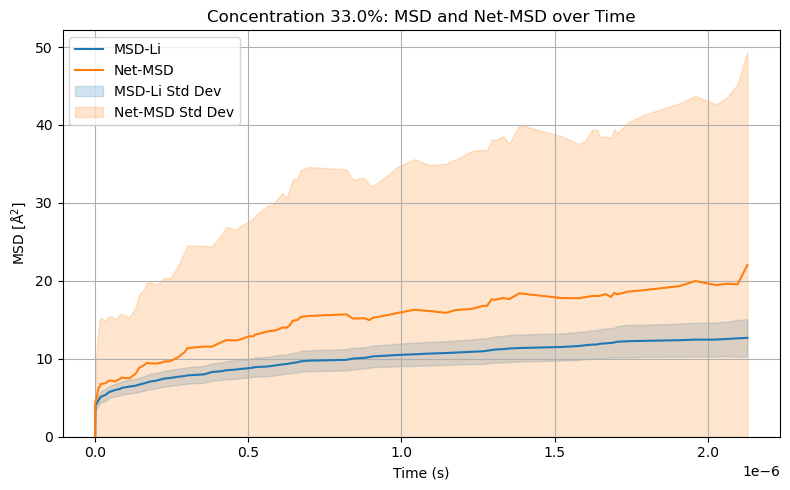

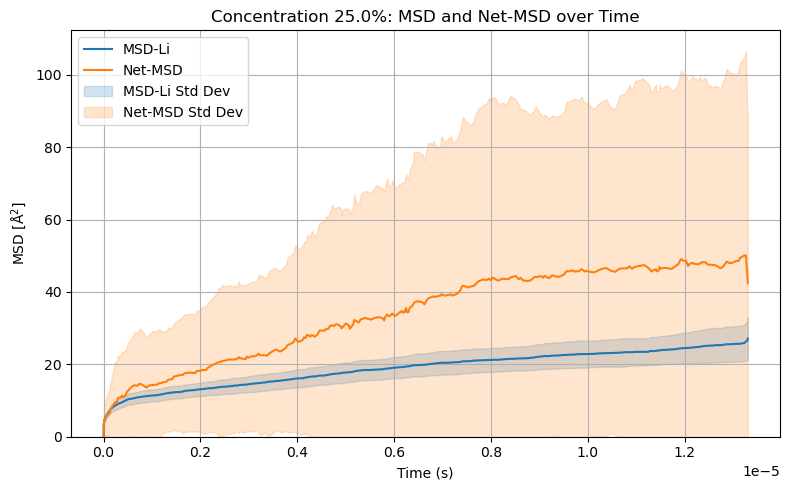

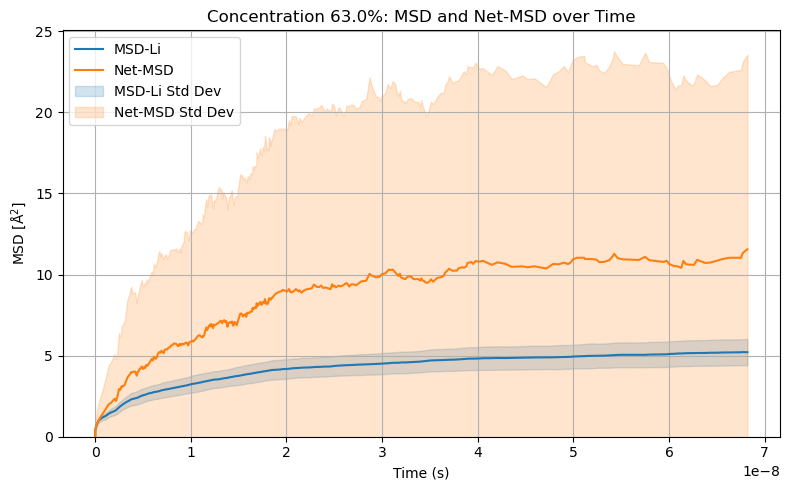

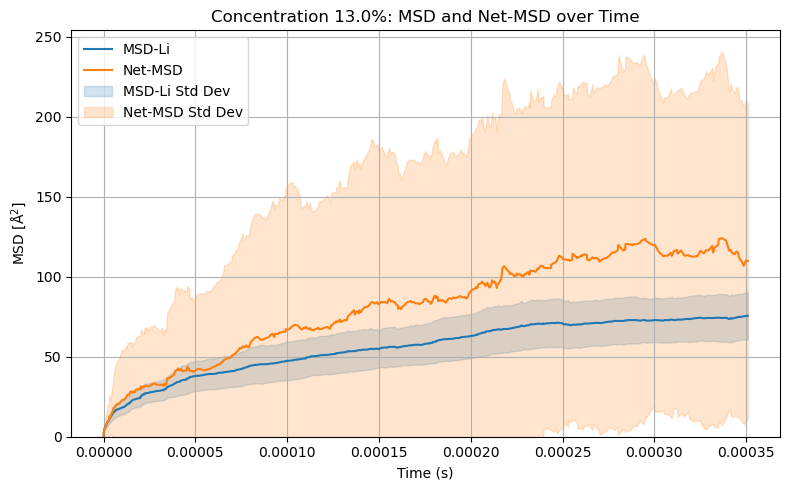

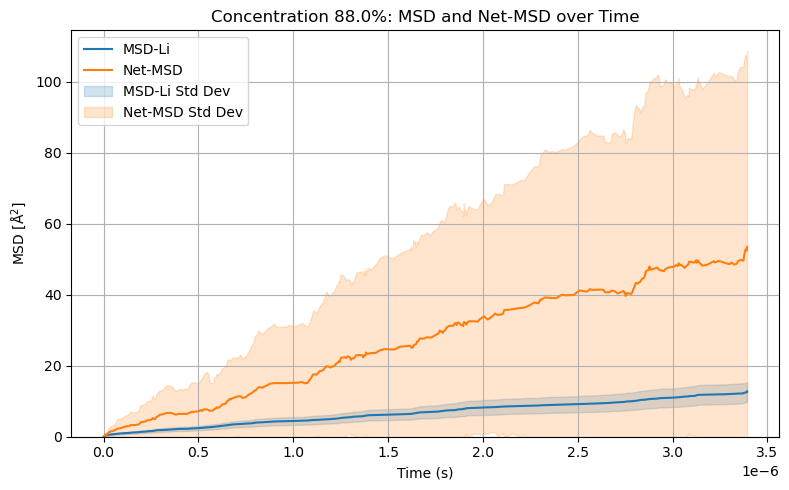

In [ ]:
# per concentration
for conc, df in dict_results.items():
    plt.figure(figsize=(8, 5))
    
    # Plot mean lines
    plt.plot(df['time'], df['msd'], label='MSD-Li')
    plt.plot(df['time'], df['net'], label='Net-MSD')
    
    # Add standard deviation bands
    plt.fill_between(df['time'], df['msd'] - df['msd_std'], df['msd'] + df['msd_std'], 
                    alpha=0.2, color='C0', label='MSD-Li Std Dev')
    
    plt.fill_between(df['time'], df['net'] - df['net_std'], df['net'] + df['net_std'], 
                    alpha=0.2, color='C1', label='Net-MSD Std Dev')
    plt.ylim(bottom=0)
    plt.xlabel('Time [s]')
    plt.ylabel('MSD [$\mathrm{{\AA}}^2$]')
    plt.title(f'Concentration {conc}%: MSD and Net-MSD over Time')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{simulation_folder}kmc_MSD_NetMSD_conc_{conc}.png', dpi=300)
    plt.show()

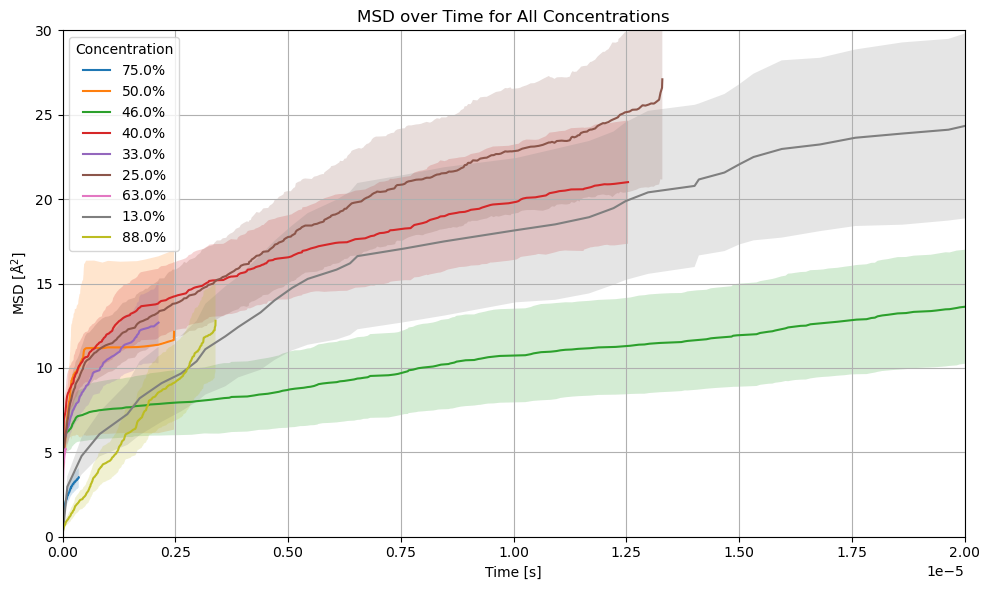

In [27]:
# just MSD but all concentrations
plt.figure(figsize=(10, 6))
for conc, df in dict_results.items():
    plt.plot(df['time'], df['msd'], label=f'{conc}%')
    plt.fill_between(df['time'], df['msd'] - df['msd_std'], df['msd'] + df['msd_std'], alpha=0.2)
    
# manually set highest graph limits for better visibility
plt.xlim(0, 2e-5)   
plt.ylim(0, 30)

plt.xlabel('Time [s]')
plt.ylabel(f'MSD [$\mathrm{{\AA}}^2$]')
plt.title('MSD over Time for All Concentrations')
plt.legend(title='Concentration')
plt.grid()
plt.tight_layout()
plt.savefig(f'{simulation_folder}kmc_MSD_all_concentrations.png', dpi=300)
plt.show()

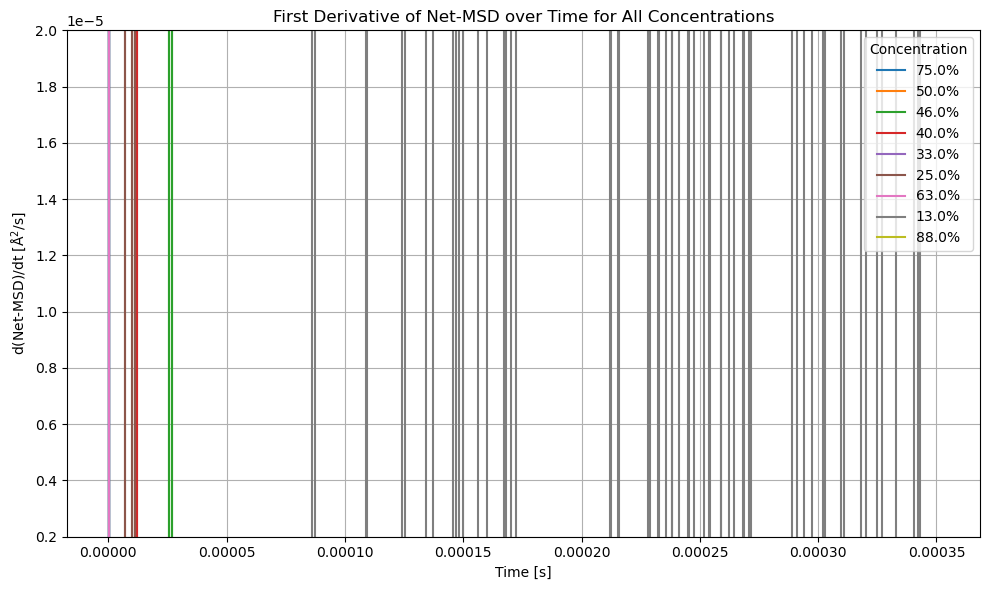

In [35]:
# Calculate and plot the first derivative (numerical gradient) of the mean Net-MSD for all concentrations

plt.figure(figsize=(10, 6))
for conc, df in dict_results.items():
    # Calculate the first derivative using numpy.gradient
    d_net = np.gradient(df['msd'], df['time'])
    plt.plot(df['time'], d_net, label=f'{conc}%')

plt.ylim(2e-6, 2e-5)  # Set y-axis limits for better visibility
plt.xlabel('Time [s]')
plt.ylabel('d(Net-MSD)/dt [$\mathrm{{\AA}}^2$/s]')
plt.title('First Derivative of Net-MSD over Time for All Concentrations')
plt.legend(title='Concentration')
plt.grid()
plt.tight_layout()
plt.savefig(f'{simulation_folder}kmc_NetMSD_derivative_all_concentrations.png', dpi=300)
plt.show()